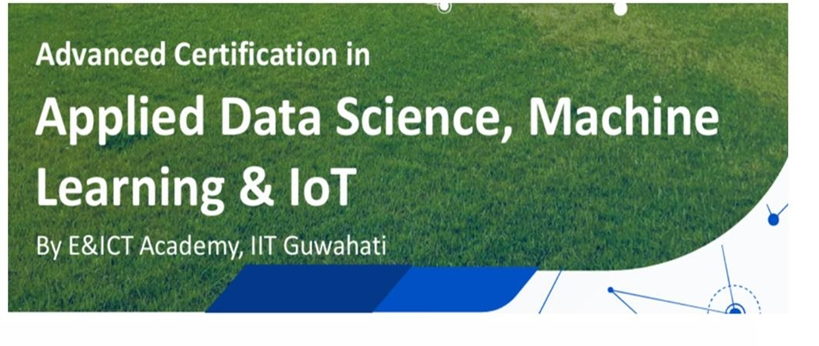

# **Capstone Project-2**
### **Title**: Zomato Recommendation System.
### **Name**: Rajesh Bisht  
### **Email**: [rbisht.india@gmail.com](mailto:rbisht.india@gmail.com)  
### **GitHub**: [https://github.com/RajeshBisht28/UnsupervisedAssignments](https://github.com/RajeshBisht28/UnsupervisedAssignments)


# 🍽️ Content-Based Restaurant Recommender System

## 🎯 Objective  
The goal is to **create a content-based recommender system** that works as follows:  

1. **Input:** Provide a restaurant name.  
2. **Process:**  
   - The system will analyze the reviews of other restaurants.  
   - It will identify restaurants with similar reviews.  
3. **Output:** Recommend restaurants with similar reviews, sorted by their ratings (highest-rated first).  

This approach focuses on understanding customer preferences through review content and suggesting restaurants that match those preferences!


### Import all required Libraries.


In [3]:
## Import Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import re
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leaflet_javaVB_delhi\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset is huge,  Load Only 3000 ROWS.

In [4]:
import pandas as pd
# Load your dataset
zomato_real = pd.read_csv('zomato.csv')
# Sample 5000 random rows
zomato_mini3000 = zomato_real.sample(n=3000, random_state=42)
# Reset the index
zomato_mini3000.reset_index(drop=True, inplace=True)
# Save the sample to a new CSV file
zomato_mini3000.to_csv('mini_zomato.csv', index=False)

In [5]:
#reading the dataset
zomato_mini = pd.read_csv('mini_zomato.csv')

# 🔧 Dropping Unnecessary Columns

To streamline the dataset for building the recommender system, we will drop the following columns:  

- **`dish_liked`**  
- **`phone`**  
- **`url`**  

These columns are not required for the recommendation system. The resulting dataset will be saved as **`zomato_mini`** for further analysis and model development.


In [42]:
try:
    zomato_mini=zomato_mini.drop(['url','dish_liked','phone'],axis=1)
except:
    pass


### Removing the Duplicates & Remove the NaN values from the dataset


In [7]:
zomato_mini.duplicated().sum()
zomato_mini.drop_duplicates(inplace=True)
#Remove the NaN values from the dataset
zomato_mini.isnull().sum()
zomato_mini.dropna(how='any',inplace=True)
#.info() function is used to get a concise summary of the dataframe
zomato_mini.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   address                      2515 non-null   object
 1   name                         2515 non-null   object
 2   online_order                 2515 non-null   object
 3   book_table                   2515 non-null   object
 4   rate                         2515 non-null   object
 5   votes                        2515 non-null   int64 
 6   location                     2515 non-null   object
 7   rest_type                    2515 non-null   object
 8   cuisines                     2515 non-null   object
 9   approx_cost(for two people)  2515 non-null   object
 10  reviews_list                 2515 non-null   object
 11  menu_item                    2515 non-null   object
 12  listed_in(type)              2515 non-null   object
 13  listed_in(city)              2515 non-

In [39]:
#Reading Column Names
zomato_mini.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city', 'Mean Rating'],
      dtype='object')

### Rename Column name as make it simple.

In [9]:
zomato_mini = zomato_mini.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato_mini.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [10]:
#Changing the cost to string for removing useless chracters. 
zomato_mini['cost'] = zomato_mini['cost'].astype(str) 
#Using lambda function to replace ',' from cost
zomato_mini['cost'] = zomato_mini['cost'].apply(lambda x: x.replace(',','.')) 
# Changing the cost to Float
zomato_mini['cost'] = zomato_mini['cost'].astype(float) 
zomato_mini.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       2515 non-null   object 
 1   name          2515 non-null   object 
 2   online_order  2515 non-null   object 
 3   book_table    2515 non-null   object 
 4   rate          2515 non-null   object 
 5   votes         2515 non-null   int64  
 6   location      2515 non-null   object 
 7   rest_type     2515 non-null   object 
 8   cuisines      2515 non-null   object 
 9   cost          2515 non-null   float64
 10  reviews_list  2515 non-null   object 
 11  menu_item     2515 non-null   object 
 12  type          2515 non-null   object 
 13  city          2515 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 294.7+ KB


In [11]:
#Reading Rate of dataset
zomato_mini['rate'].unique()

array(['3.9/5', '2.8/5', '3.5 /5', '3.5/5', '3.2/5', '3.7/5', '3.8 /5',
       'NEW', '4.2 /5', '4.2/5', '3.4 /5', '3.9 /5', '2.9/5', '3.6/5',
       '3.0/5', '3.4/5', '4.3 /5', '4.1 /5', '3.3 /5', '3.1 /5', '3.3/5',
       '4.4 /5', '3.7 /5', '3.6 /5', '4.5 /5', '4.0 /5', '3.1/5',
       '3.2 /5', '2.9 /5', '4.1/5', '4.4/5', '4.0/5', '3.8/5', '4.6 /5',
       '2.8 /5', '2.7/5', '4.3/5', '3.0 /5', '2.6/5', '2.7 /5', '4.6/5',
       '2.6 /5', '4.7 /5', '-', '4.5/5', '4.7/5', '4.9/5', '2.5 /5',
       '4.8/5', '2.3 /5', '4.8 /5', '2.4 /5', '2.4/5', '2.3/5', '2.5/5',
       '2.2/5', '2.2 /5'], dtype=object)

In [12]:
#Removing '/5'  from the 'rate' column and handle NaN values
zomato_mini = zomato_mini.loc[zomato_mini.rate !='NEW']
zomato_mini = zomato_mini.loc[zomato_mini.rate !='-'].reset_index(drop=True)

## remove_slash = lambda x: x.replace('/5', '') if type(x) == str else x
remove_slash = lambda x: x.replace('/5', '') if isinstance(x, str) else x

zomato_mini['rate'] = zomato_mini['rate'].apply(remove_slash)  # Apply the function
zomato_mini['rate'] = zomato_mini['rate'].astype(str).str.strip()  # Ensure values are strings and strip whitespace
zomato_mini['rate'] = zomato_mini['rate'].replace('nan', None).astype(float)  # Replace 'nan' string with None and convert to float
zomato_mini['rate'].head()

0    3.9
1    2.8
2    3.5
3    3.5
4    3.2
Name: rate, dtype: float64

In [13]:
# Adjust the column names
zomato_mini.name = zomato_mini.name.apply(lambda x:x.title())
zomato_mini['online_order'] = zomato_mini['online_order'].replace(('Yes', 'No'), (True, False))
zomato_mini['book_table'] = zomato_mini['book_table'].replace(('Yes', 'No'), (True, False))
zomato_mini.cost.unique()

array([250.  , 450.  , 200.  , 150.  , 300.  , 750.  ,   1.4 , 600.  ,
       400.  ,   1.  , 800.  ,   1.5 , 100.  ,   1.3 , 500.  , 700.  ,
       900.  ,   1.6 ,   1.2 , 550.  , 350.  , 650.  ,   2.6 ,   1.1 ,
         2.5 ,   1.8 ,   2.  ,   1.7 ,   3.  , 850.  ,   1.9 ,   3.4 ,
         2.2 ,   1.35,   4.1 ,   2.8 ,   4.  , 230.  ,   2.1 , 130.  ,
         1.65,   2.3 , 950.  ])

In [14]:
zomato_mini['city'].unique()

array(['BTM', 'JP Nagar', 'MG Road', 'Brigade Road', 'Kalyan Nagar',
       'Koramangala 5th Block', 'Koramangala 4th Block', 'Lavelle Road',
       'Bannerghatta Road', 'Basavanagudi', 'Residency Road',
       'Brookefield', 'Frazer Town', 'Koramangala 6th Block',
       'Church Street', 'Koramangala 7th Block', 'HSR', 'Kammanahalli',
       'New BEL Road', 'Banashankari', 'Indiranagar', 'Electronic City',
       'Jayanagar', 'Old Airport Road', 'Whitefield', 'Rajajinagar',
       'Marathahalli', 'Bellandur', 'Malleshwaram', 'Sarjapur Road'],
      dtype=object)

In [15]:
## Checking Null values
zomato_mini.isnull().sum()

address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
location        0
rest_type       0
cuisines        0
cost            0
reviews_list    0
menu_item       0
type            0
city            0
dtype: int64

In [16]:
zomato_mini.head(5)

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,"399, 16th Main, N.S Palya, BTM, Bangalore",Kalingas,True,False,3.9,179,BTM,Quick Bites,"Oriya, Fast Food",250.0,"[('Rated 3.0', 'RATED\n A pocket friendly foo...",[],Delivery,BTM
1,"1st Cross, Bilekahalli, Near IIMB College, Ban...",Angel Restaurant,True,False,2.8,165,Bannerghatta Road,Quick Bites,"Kerala, South Indian, North Indian",450.0,"[('Rated 1.0', 'RATED\n I cannot say a word a...","['Kappa', 'Kappa Biryani', 'Chicken Biryani', ...",Dine-out,JP Nagar
2,"17/1 Cambridge Road, Opposite The Frank Antony...",Paratha Xpress,False,False,3.5,8,Ulsoor,Quick Bites,"North Indian, Chinese",200.0,"[('Rated 5.0', 'RATED\n good job!'), ('Rated ...",[],Delivery,MG Road
3,"Skywalk, 5/1, Near Body Craft, Assaye Road, Ul...",Classic Lassi Shop,True,False,3.5,43,Ulsoor,Beverage Shop,"Beverages, Ice Cream",150.0,"[('Rated 3.0', 'RATED\n I have mixed feeling ...","['Fruit Salad with Ice Cream', 'Brownie with I...",Delivery,Brigade Road
4,"663, OMBR Layout, Opposite B Channsandra Bus S...",Cad (M) Cad (B),False,False,3.2,6,Banaswadi,Kiosk,Street Food,200.0,"[('Rated 2.0', 'RATED\n What ever you ask at ...",[],Desserts,Kalyan Nagar


In [17]:
# Convert 'Mean Rating' column to float to handle float values
zomato_mini['Mean Rating'] = 0.0
restaurants = list(zomato_mini['name'].unique())

# Loop through restaurants and compute mean ratings
for restaurant in restaurants:
    mean_rating = zomato_mini.loc[zomato_mini['name'] == restaurant, 'rate'].mean()
    zomato_mini.loc[zomato_mini['name'] == restaurant, 'Mean Rating'] = mean_rating


In [18]:
zomato_mini.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,"399, 16th Main, N.S Palya, BTM, Bangalore",Kalingas,True,False,3.9,179,BTM,Quick Bites,"Oriya, Fast Food",250.0,"[('Rated 3.0', 'RATED\n A pocket friendly foo...",[],Delivery,BTM,3.9
1,"1st Cross, Bilekahalli, Near IIMB College, Ban...",Angel Restaurant,True,False,2.8,165,Bannerghatta Road,Quick Bites,"Kerala, South Indian, North Indian",450.0,"[('Rated 1.0', 'RATED\n I cannot say a word a...","['Kappa', 'Kappa Biryani', 'Chicken Biryani', ...",Dine-out,JP Nagar,2.8
2,"17/1 Cambridge Road, Opposite The Frank Antony...",Paratha Xpress,False,False,3.5,8,Ulsoor,Quick Bites,"North Indian, Chinese",200.0,"[('Rated 5.0', 'RATED\n good job!'), ('Rated ...",[],Delivery,MG Road,3.5
3,"Skywalk, 5/1, Near Body Craft, Assaye Road, Ul...",Classic Lassi Shop,True,False,3.5,43,Ulsoor,Beverage Shop,"Beverages, Ice Cream",150.0,"[('Rated 3.0', 'RATED\n I have mixed feeling ...","['Fruit Salad with Ice Cream', 'Brownie with I...",Delivery,Brigade Road,3.5
4,"663, OMBR Layout, Opposite B Channsandra Bus S...",Cad (M) Cad (B),False,False,3.2,6,Banaswadi,Kiosk,Street Food,200.0,"[('Rated 2.0', 'RATED\n What ever you ask at ...",[],Desserts,Kalyan Nagar,3.2


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato_mini[['Mean Rating']] = scaler.fit_transform(zomato_mini[['Mean Rating']]).round(2)
zomato_mini.sample(3)

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
2282,"3rd Cross Road, Venkateshwara Layout, Suddagun...",The Biriyani Pedia,True,False,3.9,58,BTM,Quick Bites,"Biryani, North Indian",300.0,"[('Rated 5.0', ""RATED\n Quite easy on the poc...",[],Dine-out,Koramangala 5th Block,3.57
175,"1170, 5th Main Road, Sector 7, HSR Layout, HSR...",Asha Tiffins,True,False,4.3,286,HSR,Quick Bites,South Indian,150.0,"[('Rated 5.0', 'RATED\n Been here a couple of...","['Gobi Manchurian Dry', 'Baby Corn Manchurian ...",Delivery,Koramangala 5th Block,4.17
493,"1080, 12th Main, HAL 2nd Stage, Indiranagar, B...",Hangover,True,True,4.0,1413,Indiranagar,"Bar, Casual Dining","Thai, Chinese, North Indian, Continental, Steak",1.5,"[('Rated 3.0', ""RATED\n Good vibes, acceptabl...",[],Pubs and bars,Indiranagar,3.72


# Check Some Data visualizations...

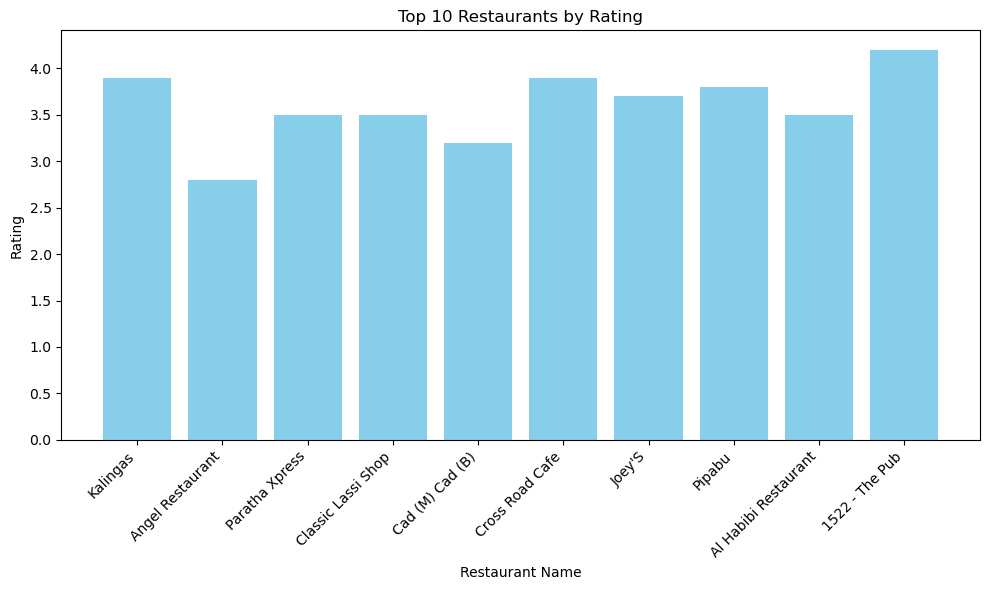

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Zomato dataset
# Replace 'zomato.csv' with the path to your dataset
data = zomato_mini.copy() 
# Sort the data by Review Count in descending order
data_subset = data.sort_values(by='votes', ascending=False)
data_unique = data.drop_duplicates(subset='name', keep='first')

# Select the top 10 restaurants with the highest review counts for better visualization
top_restaurants = data_unique.head(10)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_restaurants['name'], top_restaurants['rate'], color='skyblue')
plt.xlabel('Restaurant Name')
plt.ylabel('Rating')
plt.title('Top 10 Restaurants by Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


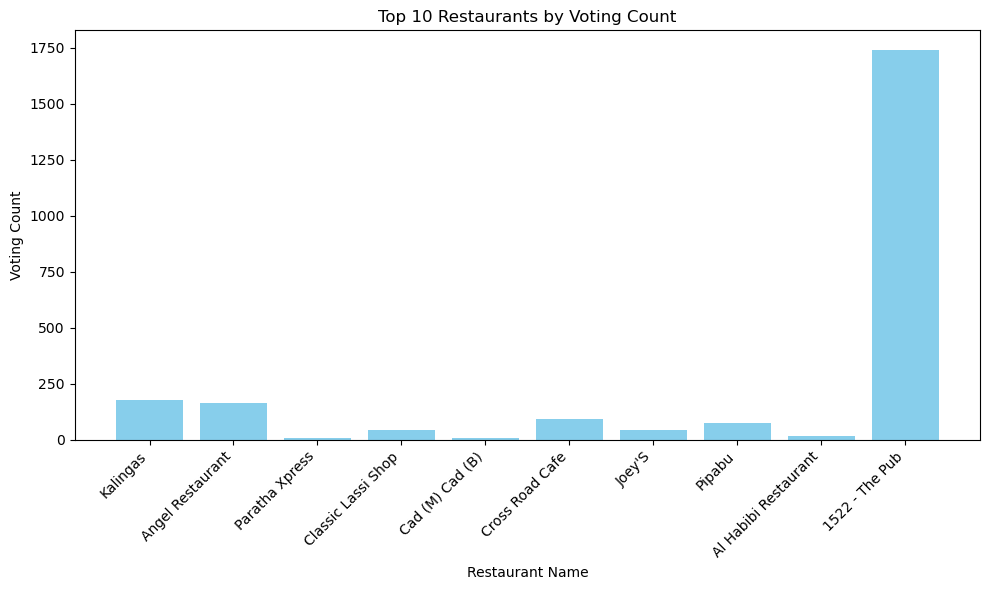

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Zomato dataset
# Replace 'zomato.csv' with the path to your dataset
data = zomato_mini.copy() 
# Sort the data by Review Count in descending order
data_subset = data.sort_values(by='votes', ascending=False)
data_unique = data.drop_duplicates(subset='name', keep='first')

# Select the top 10 restaurants with the highest review counts for better visualization
top_restaurants = data_unique.head(10)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_restaurants['name'], top_restaurants['votes'], color='skyblue')
plt.xlabel('Restaurant Name')
plt.ylabel('Voting Count')
plt.title('Top 10 Restaurants by Voting Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


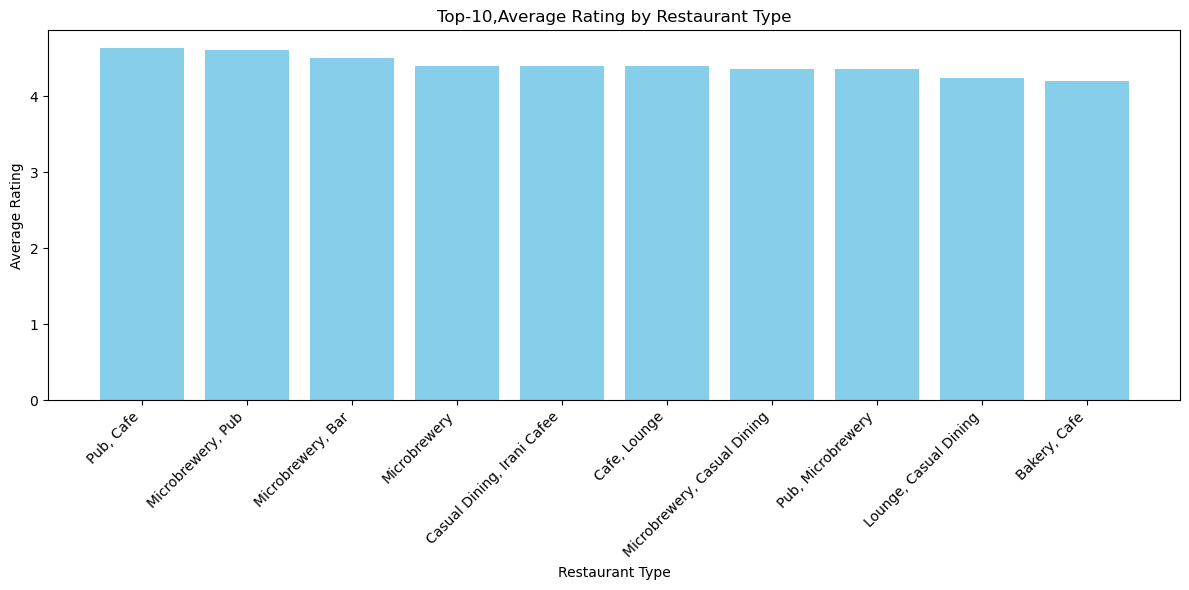

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Zomato dataset
data = zomato_mini.copy()

# Group by 'rest_type' and calculate the mean rate
avg_rate_by_type = data.groupby('rest_type')['rate'].mean().reset_index()

# Sort the data for better visualization
avg_rate_by_type = avg_rate_by_type.sort_values(by='rate', ascending=False)
avg_rates = avg_rate_by_type.head(10)
# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(avg_rates['rest_type'], avg_rates['rate'], color='skyblue')
plt.xlabel('Restaurant Type')
plt.ylabel('Average Rating')
plt.title('Top-10,Average Rating by Restaurant Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Common Text Preprocessing / Cleaning Steps

Some of the common text preprocessing or cleaning steps are:

- **Lower casing**: Convert all text to lowercase to maintain uniformity.
- **Removal of Punctuations**: Remove special characters and punctuation marks.
- **Removal of Stopwords**: Eliminate commonly used words that do not add significant meaning (e.g., "and", "the", "is").
- **Removal of URLs**: Strip out any web links from the text.
- **Spelling correction**: Correct misspelled words for better accuracy.


In [23]:
# 5 examples of these columns before text processing:
zomato_mini[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
2046,"[('Rated 4.0', ""RATED\n Food was very good. G...","North Indian, Chinese, South Indian, Street Food"
760,"[('Rated 4.0', ""RATED\n One of the easiest an...","North Indian, Biryani, Fast Food"
948,"[('Rated 5.0', 'RATED\n One of my go to place...","Beverages, Fast Food"
1108,"[('Rated 4.0', ""RATED\n Ice creams are really...",Ice Cream
1243,[],South Indian


In [24]:
## Lower Casing
zomato_mini["reviews_list"] = zomato_mini["reviews_list"].str.lower()
zomato_mini[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
836,"[('rated 5.0', 'rated\n such a great hangout!...","Fast Food, Lebanese"
1343,"[('rated 4.5', 'rated\n visited this place al...","South Indian, Street Food, Juices"
425,"[('rated 5.0', 'rated\n please provide some e...","Cafe, South Indian"
173,"[('rated 4.0', 'rated\n good place and staff ...","Continental, Mexican, Lebanese"
932,"[('rated 1.0', ""rated\n i tried this place be...","Fast Food, North Indian"


In [25]:
zomato_mini.shape

(2371, 15)

In [26]:
## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

zomato_mini["reviews_list"] = zomato_mini["reviews_list"].apply(lambda text: remove_punctuation(text))
zomato_mini[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
49,rated 40 ratedn nice restaurant for south ind...,South Indian
2333,rated 50 ratedn finger licking hyderabadi dum...,"Biryani, Hyderabadi, Chinese"
1437,rated 50 ratedn if you are located within 5km...,"North Indian, Continental, Chinese"
1028,rated 40 ratedn if you are looking for pure s...,South Indian
564,rated 30 ratedn went there for team lunch apa...,"American, Continental, Steak, Salad"


#### NLP : Removal of Stopwords.

In [43]:
## Removal of Stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

zomato_mini["reviews_list"] = zomato_mini["reviews_list"].apply(lambda text: remove_stopwords(text))

In [44]:
## Removal of URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

zomato_mini["reviews_list"] = zomato_mini["reviews_list"].apply(lambda text: remove_urls(text))

In [45]:
zomato_mini[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
2199,rated 40 ratedn jetlag weird name given restob...,"Finger Food, Continental, North Indian, Italia..."
1846,rated 40 ratedn place twice like food ambiance...,"Bakery, Desserts"
1506,rated 30 ratedn first glance nasi mee definite...,"Malaysian, Thai, Singaporean, Asian, Chinese, ..."
312,rated 50 ratedn searching eat jamun seen zomat...,"Mithai, Street Food"
192,rated 45 ratedn closest amazing imli chutney g...,"North Indian, Chinese"


In [46]:
# RESTAURANT NAMES:
restaurant_names = list(zomato_mini['name'].unique())
restaurant_names[:13]

['Kalingas',
 'Angel Restaurant',
 'Paratha Xpress',
 'Classic Lassi Shop',
 'Cad (M) Cad (B)',
 'Cross Road Cafe',
 "Joey'S",
 'Pipabu',
 'Al Habibi Restaurant',
 '1522 - The Pub',
 "Cafe D'Hide",
 'Ascharya Hotel',
 'Crown Gold']

# Term Frequency-Inverse Document Frequency (TF-IDF)

**Term Frequency-Inverse Document Frequency (TF-IDF)** is a method to create vectors for each document. This results in a matrix where:  
- Each **column** represents a word in the overview vocabulary (all the words that appear in at least one document).  
- Each **row** represents a document, such as a restaurant description.

TF-IDF is a statistical method for evaluating the significance of a word in a given document.  

### Key Concepts:

- **TF (Term Frequency):**  
  Refers to how many times a given term appears in a document.

- **IDF (Inverse Document Frequency):**  
  Measures the weight of the word in the document, i.e., whether the word is common or rare across the entire corpus.  

The intuition behind TF-IDF is that terms appearing frequently in a document are less important than terms that appear rarely.  

### Implementation Tip:  
Scikit-learn provides a built-in `TfidfVectorizer` class to generate the 


In [32]:
#!pip install wordcloud

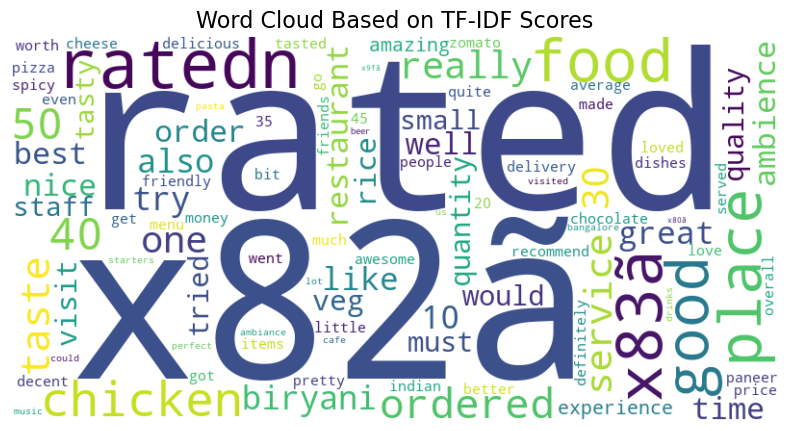

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample data: Replace with your text/reviews column
documents = zomato_mini['reviews_list']  # Replace 'reviews' with the name of your text column

# Step 1: Compute TF-IDF scores
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Step 2: Generate the Word Cloud
wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(tfidf_scores)

# Step 3: Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Based on TF-IDF Scores", fontsize=16)
plt.show()


In [52]:
df = zomato_mini.copy()
# Trim leading and trailing spaces from the 'name' column
df['name'] = df['name'].str.strip()
df['name'].head(5)

0              Kalingas
1      Angel Restaurant
2        Paratha Xpress
3    Classic Lassi Shop
4       Cad (M) Cad (B)
Name: name, dtype: object

### Create a recommendation function, using Cosine Similarity.

In [61]:
# Recommendation function
def recommend_restaurants(name, cosine_sim, df, top_n=6):
    #print(df.head(20))
     # Find the index of the restaurant by its name 
    index = -1
    if name in df['name'].values:
       index = df[df['name'] == name].index[0]
    else:
        print(f" {name} : not found in dataset")
        return []
    
    # Get similarity scores for the given restaurant
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # Sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the top N most similar restaurants (excluding itself)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    # Return the restaurant names
    return df.iloc[top_indices]['name'].values

In [57]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Combine reviews for each restaurant
df['reviews_combined'] = df['reviews_list'].apply(lambda x: ' '.join(x.split()) if pd.notnull(x) else '')
# Vectorize the reviews using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['reviews_combined'])
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")


Cosine similarity matrix shape: (2371, 2371)


### Check Recommendation based on Restaurant Name
***Ask Restaurant Name From User***

In [65]:
rest_name = input("Enter the name of the restaurant: ")
#rest_name = "Kalingas"
top_recommendations = recommend_restaurants(rest_name, cosine_sim, df, 6)

if(len(top_recommendations)==0):
    print("Restaurant Name Could Not Find.")
else:
    print(f"\n =============== Top-6 Recomended for Restaurant:: '{rest_name}' ====================")
    recommendations_df = pd.DataFrame({'Rank': range(1, total_len+1), 'Restaurant Name': top_recommendations})
    print(recommendations_df)

Enter the name of the restaurant:  Bansuri Sweets



 =============== Top-6 Recomended for Restaurant:: 'Bansuri Sweets' ====================
   Rank          Restaurant Name
0     1                Chowpatty
1     2  Soda Bottle Opener Wala
2     3            Cafe @ Elanza
3     4              Antigravity
4     5                    Smoor
5     6       1992 Chats - Space
